### 1. Dataset

In [1]:
%%time
import os
import logging
from marss2l.utils import setup_stream_logger, get_remote_filesystem, pathjoin

logger = logging.getLogger(__name__)
setup_stream_logger(logger, level=logging.DEBUG)

os.makedirs("figures", exist_ok=True)

CPU times: user 1.7 s, sys: 1.72 s, total: 3.42 s
Wall time: 1.41 s


In [2]:
from marss2l import loaders
fs = get_remote_filesystem()

Using account key


In [3]:
from marss2l.plot import C0, C1, C2, C3, C4

We are using the test set to figure out the MDL:

In [4]:
from marss2l import loaders
# Import the dataset
csv_path = "az://public/MARS-S2L/dataset_20250609/validated_images_all.csv"
dataframe_data_traintest = loaders.read_csv(csv_path, 
                                            add_columns_for_analysis=True, 
                                            add_case_study=True,
                                            split="all",
                                            fs=None)
dataframe_data_traintest.shape

Using account key


(93581, 58)

In [5]:
# Have a look at the table columns, for reference
dataframe_data_traintest.columns

Index(['id_loc_image', 's2path', 'plumepath', 'cloudmaskpath', 'ch4path',
       'location_name_short', 'wind_u', 'wind_v', 'wind_speed', 'vza', 'sza',
       'percentage_clear', 'tile', 'isplume', 'ch4_fluxrate',
       'ch4_fluxrate_std', 'satellite', 'tile_date', 'notified', 'id_location',
       'last_update', 'location_name', 'country', 'lon', 'lat', 'offshore',
       'sector', 'monitoring', 'observability', 'background_image_tile',
       'footprint', 'plume', 'crs', 'transform_a', 'transform_b',
       'transform_c', 'transform_d', 'transform_e', 'transform_f', 'width',
       'height', 'window_row_off', 'window_col_off', 'window_height',
       'window_width', 'split_name', 'percent_overlap', 'year', 'year_month',
       'year_month_day', 'isplumeneg', 'date', 'satellite_constellation',
       'year_quarter', 'ch4_fluxrate_th', 'interval_ch4_fluxrate',
       'interval_ch4_fluxrate_str', 'case_study'],
      dtype='object')

Statistics are made with true positives

In [6]:
# Take positives only
case_studies_exclude = ["Rest","Offshore","Venezuela"]

df_data = dataframe_data_traintest[(dataframe_data_traintest["ch4_fluxrate"] > 0) &\
                                   (dataframe_data_traintest['split_name']=='test_2023') &\
                                   (~dataframe_data_traintest.case_study.isin(case_studies_exclude))]
# Filter by country
# df_data = df_data[df_data['country']=='Algeria']
df_data.case_study.value_counts()

case_study
Turkmenistan                  853
Algeria                       296
United States of America      144
Libya                         121
Arabian peninsula             103
Syrian Arab Republic           99
Iran (Islamic Republic of)     70
Uzbekistan & Kazakhstan        43
Egypt                          24
Iraq                            7
Name: count, dtype: int64

Make a different list for each satellite:

In [7]:
# Satellites in the dataset
satellites = df_data.satellite_constellation.unique()
# Observations with each satellite
data = {satellite: df_data[df_data["satellite_constellation"]==satellite] for satellite in satellites}
# Print the number of observations
[print(data[satellite].shape[0], satellite) for satellite in satellites]

1048 Sentinel-2
712 Landsat


[None, None]

### 4. Empirical distributions

Measure the frequency of detections for 200 kg/h interval:

In [8]:
import numpy as np
# Number of plumes by country
country_tables = [data[satellite]['country'].value_counts() for satellite in satellites]; #print(country_table)
# Define the bins
bins = range(0, 20000, 100)
# Histogram of flowrates
q_hists = {satellite: np.histogram(data[satellite]['ch4_fluxrate'], bins = bins, density = True) for satellite in satellites}

Show the results for each satellite:

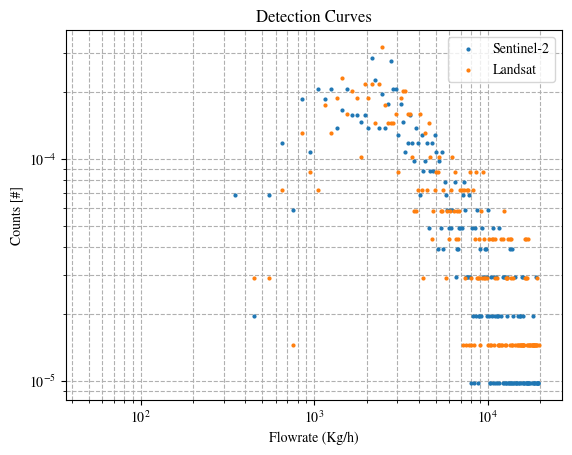

In [9]:
import numpy as np
import matplotlib.pylab as plt
# Centre of the labels
cntr = np.array([(bins[i+1]+bins[i])/2 for i in range(0, len(bins)-1)])
# Show the cumulative count
fig, ax = plt.subplots()
[ax.scatter(cntr, q_hists[satellite][0], s = 4, label = satellite) for satellite in satellites]
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlabel("Flowrate (Kg/h)"); ax.set_ylabel('Counts [#]')
ax.set_axisbelow(True)
plt.title('Detection Curves'); plt.grid(True, which="both", ls="--"); plt.legend()

The model that describes the frequencies is the combination of two distribution funcitons: (1) a logistic function that represents the `Probability of Detection (PoD)` and (2) a power law equation representing the `Theoretical Plume Frequency Distribution (PFD)`. The response of every instrument is a combination of the two, which is the PoD multiplied by the PFD.

In [10]:
from scipy.stats import gamma

def pod(x, a, b):
    ''' Probability of detection as logistic function
    :param x: float. Flowrate.
    :param a: float. Steepness.
    :param b: float. Midpoint.
    '''
    # return gamma.pdf(x, a, b, c)
    return 1/(1 + 10**(-a*( x - b)))

def pfd(x, A, B):
    ''' Plume frequency distribution as power law
    :param x: float. Flowrate.
    :param A: float. Slope.
    :param B: float. Bias.
    '''
    return np.exp(A * np.log(x) + B)

def system_equations(x, a, b, A, B):
    # def system_equations(x, a, b, A, B):
    # return pod(x, a, b, c)
    return pod(x, a, b) * pfd(x, A, B)


Fit the equations to the histogram of every satellite:

In [11]:
from scipy.optimize import curve_fit
# Initial guess of the parameters - at the moment, very dependent on initial guess
initial_guess = [1, 1, -1, -1]
initial_guess = [0.001, 1000, -1, -1]
# Initialize the parameters
popts = {}; pcovs = {}
# For every satellite fit the curves
for satellite in satellites:
    # Flowrates as independent, Counts as depedent
    x = cntr; y = q_hists[satellite][0]
    # Avoid 0 values in counts
    x = x[y > 0]; y = y[y > 0]
    # Compute the parameters
    popt, pcov = curve_fit(system_equations, x, y, p0=initial_guess)
    # Save the results
    popts.update({satellite: popt})
    pcovs.update({satellite: pcov})

Prepare a Monte Carlo simulation considering all the uncertainties involved:

In [12]:
# Number of Monte Carlo runs
n = 1000
# Bins to count the frequency of flowrates
cntr = np.array([(bins[i+1]+bins[i])/2 for i in range(0, len(bins)-1)])
# Flowrates to compute the PoD
flw = np.linspace(0, 4000, 4000)
# Save modellign results for reach satellite
model_means = {}; model_sds = {}
pod_means = {}; pod_sds = {}
# For every satellite fit the curves
for satellite in satellites:
    # Results of the simulations of frequencies
    freq = np.ones((n, len(cntr)))
    # Results of the simulations of PoDs
    pods = np.ones((n, len(flw)))
    # Sample the parameter distribution
    params = np.random.multivariate_normal(popts[satellite], pcovs[satellite], size = n)
    # Rund the model multiple times
    for i in range(n):
        # Compute the frequencies with these parameters
        freq[i,:] = system_equations(cntr, params[i, 0], params[i, 1], params[i, 2], params[i,3])
        pods[i,:] = pod(flw,  params[i, 0], params[i, 1])
        # Compute the pods
    # Compute statistics
    freq_model_mu = np.mean(freq, axis = 0); model_means.update({satellite: freq_model_mu})
    freq_model_sd = np.std(freq, axis = 0); model_sds.update({satellite: freq_model_sd})
    pod_model_mu = np.mean(pods, axis = 0); pod_means.update({satellite: pod_model_mu})
    pod_model_sd = np.std(pods, axis = 0); pod_sds.update({satellite: pod_model_sd})

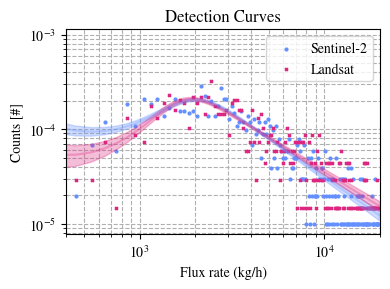

In [13]:
import matplotlib.pylab as plt
# Set the colors and markers
colors = {'Sentinel-2':C0, 'Landsat':C2}
markers = {'Sentinel-2':'o', 'Landsat':'x'}
# Initialize the plots
fig, ax = plt.subplots(1,1, figsize=(4, 3), tight_layout=True)
# Show the frequency dots
[ax.scatter(cntr, q_hists[satellite][0], s = 4, label = satellite, color = colors[satellite], marker=markers[satellite]) for satellite in satellites]
# Show the mean value of the curve
[ax.plot(cntr, model_means[satellite], alpha = 0.3, color = colors[satellite]) for satellite in satellites]
# And the standard deviations
[ax.fill_between(cntr, 
                 model_means[satellite]-model_sds[satellite], 
                 model_means[satellite]+model_sds[satellite], 
                 color = colors[satellite], alpha = 0.3) for satellite in satellites]
# Formatring
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlabel("Flux rate (kg/h)"); ax.set_ylabel('Counts [#]')
ax.set_xlim(400,20000)
ax.set_axisbelow(True)
plt.title('Detection Curves'); plt.grid(True, which="both", ls="--"); plt.legend()
plt.savefig("figures/detection_curves_by_satellite.pdf")

In [14]:
# Compute the MDLs at 50 and 90% probability
mdls = {satellite: [{'Q50_min':int(round(flw[np.where((pod_means[satellite]+pod_sds[satellite]) > 0.5)[0][0]]))},
                    {'Q50_mean':int(round(flw[np.where(pod_means[satellite] > 0.5)[0][0]]))},
                    {'Q50_max':int(round(flw[np.where((pod_means[satellite]-pod_sds[satellite]) > 0.5)[0][0]]))},
                    {'Q90_min':int(round(flw[np.where((pod_means[satellite]+pod_sds[satellite]) > 0.9)[0][0]]))},
                    {'Q90_mean':int(round(flw[np.where((pod_means[satellite]) > 0.9)[0][0]]))},
                    {'Q90_max':int(round(flw[np.where((pod_means[satellite]-pod_sds[satellite]) > 0.9)[0][0]]))}]
            for satellite in satellites}
# Print the results
mdls

{'Sentinel-2': [{'Q50_min': 1535},
  {'Q50_mean': 1607},
  {'Q50_max': 1683},
  {'Q90_min': 2335},
  {'Q90_mean': 2453},
  {'Q90_max': 2558}],
 'Landsat': [{'Q50_min': 1407},
  {'Q50_mean': 1476},
  {'Q50_max': 1553},
  {'Q90_min': 2043},
  {'Q90_mean': 2174},
  {'Q90_max': 2289}]}

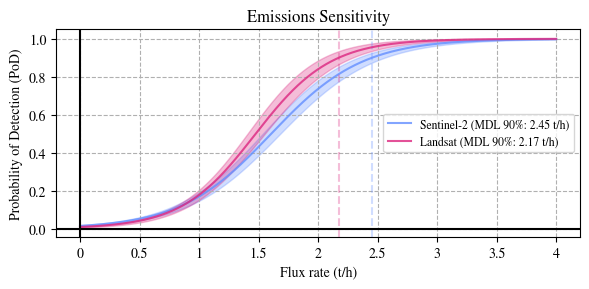

In [15]:
# Show the probabilities of detection for each satellite
from marss2l.plot import recall_fluxrate_plot
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)

# Plot curves and confidence bands for each satellite
for satellite in satellites:
    # Get the mean probability of detection
    mean_pod = pod_means[satellite]
    # Get the color for this satellite
    satellite_color = colors[satellite]
    # Get the MDL value (90% detection threshold)
    mdl_value = mdls[satellite][4]['Q90_mean']
    
    # Create legend label with MDL included
    legend_label = f"{satellite} (MDL 90%: {mdl_value/1000:.2f} t/h)"
    
    # Plot mean probability curve
    ax.plot(flw, mean_pod, alpha=0.8, label=legend_label, color=satellite_color)
    
    # Add confidence bands
    lower_bound = mean_pod - pod_sds[satellite]
    upper_bound = mean_pod + pod_sds[satellite]
    ax.fill_between(flw, lower_bound, upper_bound, alpha=0.3, color=satellite_color)
    
    # Draw vertical line at 90% detection threshold
    ax.axvline(mdl_value, color=satellite_color, alpha=0.3, linestyle='--')

# Add reference lines
ax.axhline(0, color='black')
ax.axvline(0, color='black')

# Format x-axis ticks using the fluxrate_to_str function
ax.set_xticks(range(0, 4_100, 500))
x_tick_labels = [recall_fluxrate_plot.fluxrate_to_str(d/1000) for d in range(0, 4_100, 500)]
ax.set_xticklabels(x_tick_labels)

# Add title and axis labels
ax.set_title('Emissions Sensitivity')
ax.set_xlabel('Flux rate (t/h)')
ax.set_ylabel('Probability of Detection (PoD)')

# Add grid and legend
ax.grid(linestyle='--')
ax.legend(fontsize='small', loc='best')
plt.savefig("figures/mdl_by_satellite.pdf")